In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report
)
from sklearn.calibration import calibration_curve

In [7]:
# === 1. Load data ===
train = pd.read_csv('C:/Users/kdh02/Datasets/train.csv')
test  = pd.read_csv('C:/Users/kdh02/Datasets/test.csv')
sample_sub = pd.read_csv('C:/Users/kdh02/Datasets/sample_submission.csv')

In [8]:
# === 2. Define columns ===
id_col     = 'id'
drop_cols  = ['CustomerId', 'Surname']
target_col = 'Exited'

In [9]:
# === 3. Split features & target ===
X_train = train.drop(drop_cols + [id_col, target_col], axis=1)
y_train = train[target_col]
X_test  = test .drop(drop_cols + [id_col], axis=1)

In [10]:
# === 4. Preprocess: median impute + LabelEncoder on combined ===
combined = pd.concat([X_train, X_test], ignore_index=True)

# 4-1) Numeric imputation
num_cols = combined.select_dtypes(include=['int64','float64']).columns
imputer  = SimpleImputer(strategy='median')
combined[num_cols] = imputer.fit_transform(combined[num_cols])

# 4-2) Categorical → Label Encoding
cat_cols = combined.select_dtypes(include=['object']).columns
for col in cat_cols:
    combined[col] = LabelEncoder().fit_transform(combined[col].astype(str))

# 4-3) Split back into train/test
X_tr_enc = combined.iloc[:len(X_train), :].reset_index(drop=True)
X_te_enc = combined.iloc[len(X_train): , :].reset_index(drop=True)

# === 5. Train on full data and save submission ===
model_full = RandomForestClassifier(n_estimators=100, random_state=42)
model_full.fit(X_tr_enc, y_train)

submission = sample_sub.copy()
submission[target_col] = model_full.predict_proba(X_te_enc)[:, 1]
submission.to_csv('C:/Users/kdh02/Datasets/submission_original.csv', index=False)
print("submission_original.csv 생성 완료")
print(submission.head())

submission_original.csv 생성 완료
       id  Exited
0  165034   0.020
1  165035   0.910
2  165036   0.000
3  165037   0.185
4  165038   0.290


In [11]:
# === 6. Validation split & retrain for evaluation ===
X_tr, X_val, y_tr, y_val = train_test_split(
    X_tr_enc, y_train, test_size=0.2, random_state=42
)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_tr, y_tr)
y_proba = model.predict_proba(X_val)[:, 1]
y_pred  = (y_proba >= 0.5).astype(int)


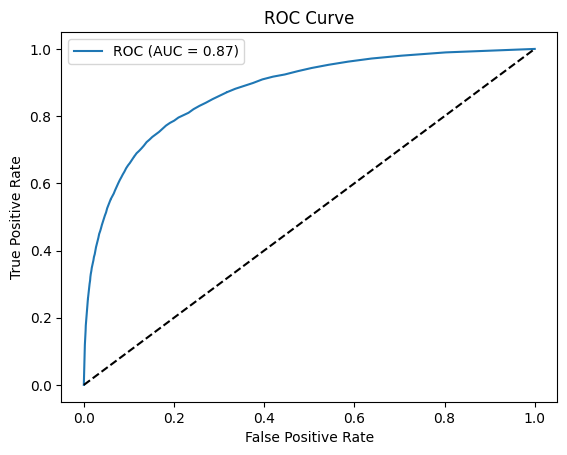

In [12]:
# === 7. ROC Curve ===
fpr, tpr, _ = roc_curve(y_val, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

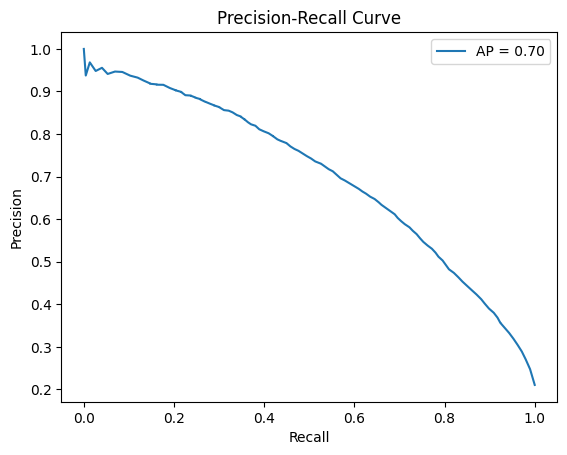

In [13]:
# === 8. Precision–Recall Curve ===
precision, recall, _ = precision_recall_curve(y_val, y_proba)
ap = average_precision_score(y_val, y_proba)
plt.figure()
plt.plot(recall, precision, label=f'AP = {ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

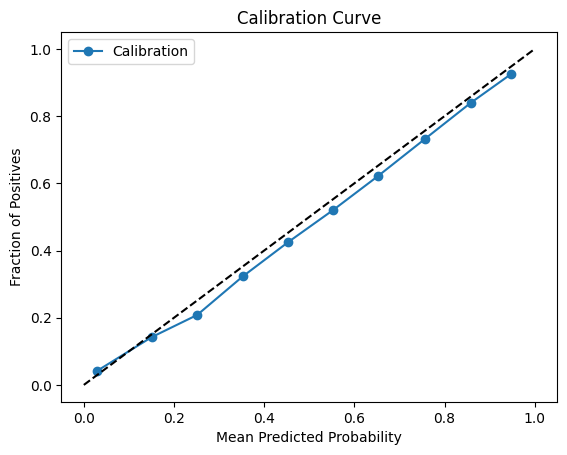

In [14]:
# === 9. Calibration Curve ===
prob_true, prob_pred = calibration_curve(y_val, y_proba, n_bins=10)
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', label='Calibration')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

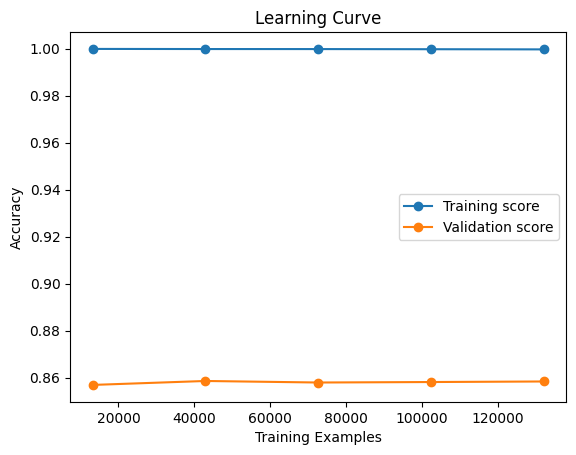

In [15]:
# === 10. Learning Curve ===
train_sizes, train_scores, val_scores = learning_curve(
    RandomForestClassifier(n_estimators=100, random_state=42),
    X_tr_enc, y_train,
    cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='accuracy'
)
train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)
plt.figure()
plt.plot(train_sizes, train_mean, 'o-', label='Training score')
plt.plot(train_sizes, val_mean,   'o-', label='Validation score')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()



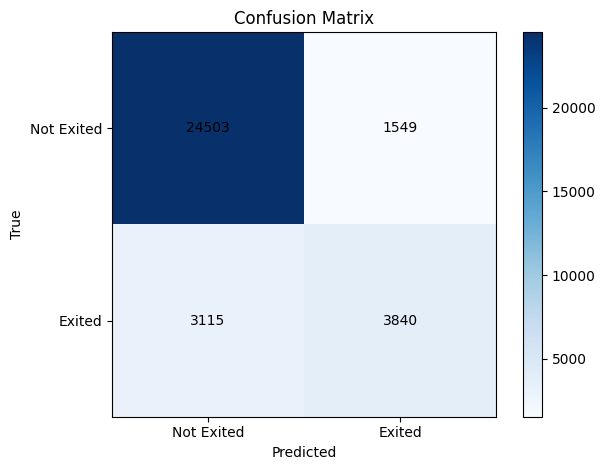

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     26052
           1       0.71      0.55      0.62      6955

    accuracy                           0.86     33007
   macro avg       0.80      0.75      0.77     33007
weighted avg       0.85      0.86      0.85     33007



In [16]:
# === 11. Confusion Matrix & Classification Report ===
cm = confusion_matrix(y_val, y_pred)
plt.figure()
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
ticks = np.arange(2)
plt.xticks(ticks, ['Not Exited','Exited'])
plt.yticks(ticks, ['Not Exited','Exited'])
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, cm[i, j], ha='center', va='center')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

print("Validation Classification Report:")
print(classification_report(y_val, y_pred))
